In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import uproot
import awkward as ak
from pathlib import Path
import joblib

import mplhep as hep

hep.style.use(hep.style.ATLAS)

from typing import Dict, List
import re
import pickle
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

# Prepare Samples

In [2]:
merged_sig_path = "./merged_decorated_sig.pkl"
merged_bkg_path = "./merged_decorated_bkg.pkl"

merged_sig = joblib.load(merged_sig_path)
merged_bkg = joblib.load(merged_bkg_path)

In [3]:
merged_sig["target"] = np.ones(len(merged_sig))
merged_bkg["target"] = np.zeros(len(merged_bkg))

In [4]:
merged_sig.head()

,Yields,isMC,Channel,Year,NormSF,WeightSign,WeightNormalized,Weight,M_WZ,M_123,...,Lep3WeightZ,Lep1WeightW,Lep2WeightW,Lep3WeightW,Lep1Level,Lep2Level,Lep3Level,Ht,pSignal_GM,target
3,0,450765,3,1516,0.783916,0.0,-0.079258,-0.101105,187.706635,144.789856,...,0.997051,0.969956,0.990138,0.995931,123,123,123,508.242188,0.781384,1.0
11,0,450765,2,1516,0.783916,0.0,-0.053379,-0.068093,270.459198,156.205460,...,0.988552,0.996840,0.998581,0.978706,123,123,123,295.828552,0.887640,1.0
14,0,450765,3,1516,0.783916,0.0,0.042182,0.053809,196.065414,165.009293,...,0.999236,0.971638,0.966696,0.998496,123,123,123,274.689301,0.922267,1.0
16,0,450765,2,1516,0.783916,0.0,-0.066834,-0.085256,200.703903,140.544388,...,0.956663,0.995598,0.981509,0.902356,123,123,123,288.953735,0.939477,1.0
22,0,450765,1,1516,0.783916,0.0,0.072323,0.092259,221.749603,144.889526,...,0.999727,0.990660,0.975106,0.995559,123,123,123,261.893311,0.621475,1.0


In [5]:
merged_bkg.head()

,Yields,isMC,Channel,Year,NormSF,WeightSign,WeightNormalized,Weight,M_WZ,M_123,...,Lep3WeightZ,Lep1WeightW,Lep2WeightW,Lep3WeightW,Lep1Level,Lep2Level,Lep3Level,Ht,pSignal_GM,target
3,0,364253,1,1516,0.03081,-1.0,0.003436,0.111508,264.512421,162.948868,...,0.976912,0.984519,0.966683,0.972876,123,123,123,564.105957,0.474402,0.0
7,0,364253,2,1516,0.03081,-1.0,0.001967,0.063848,581.739746,542.020996,...,0.994135,0.963180,0.991485,0.989407,123,123,123,1407.941895,0.055484,0.0
8,0,364253,1,1516,0.03081,-1.0,0.004380,0.142154,180.702271,126.432777,...,0.996336,0.982291,0.992726,0.993438,123,123,123,449.234253,0.561984,0.0
9,0,364253,1,1516,0.03081,-1.0,0.003606,0.117033,421.647491,330.038269,...,0.989995,0.997536,0.987993,0.990398,122,123,123,235.120377,0.063376,0.0
25,0,364253,2,1516,0.03081,-1.0,-0.003694,-0.119899,297.623383,200.659470,...,0.969941,0.995724,0.999789,0.953116,123,123,123,481.822632,0.723610,0.0


In [6]:
len(merged_sig)

868074

In [7]:
len(merged_bkg)

932335

In [8]:
sample = pd.concat([merged_sig, merged_bkg])

In [9]:
len(sample)

1800409

In [10]:
joblib.dump(sample, "training_sample.pkl")

['training_sample.pkl']

# Training

In [11]:
X = sample.iloc[:, :-1]
y = sample.iloc[:, -1]

X_dev, X_test, y_dev, y_test = train_test_split(
    X, y, test_size=0.1, random_state=456
)
X_train, X_val, y_train, y_val = train_test_split(
    X_dev, y_dev, test_size=0.1 / 0.9, random_state=789
)

In [12]:
training_features = [
    "Deta_jj",
    "Dphi_jj",
    "M_jj",
    "Met",
    "ZetaLep",
    "Jet1Pt",
    "Jet1Eta",
    "Jet2Pt",
    "Jet2Eta",
    "Ht",
    "Eta_W",
    "Eta_Z",
    "Lep1Eta",
    "Lep2Eta",
    "Lep3Eta",
]

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train[training_features])
X_train[training_features] = scaler.transform(X_train[training_features])
X_test[training_features] = scaler.transform(X_test[training_features])

In [14]:
clf = MLPClassifier(
    solver="adam",
    alpha=1e-5,
    learning_rate="constant",
    learning_rate_init=0.01,
    hidden_layer_sizes=(50, 50),
    random_state=42,
    verbose=True,
    max_iter=100,
    validation_fraction=0.1,
    early_stopping=True,
    n_iter_no_change=10,
)

clf.fit(X_train[training_features], y_train)

Iteration 1, loss = 0.27653204
Validation score: 0.888775
Iteration 2, loss = 0.27118767
Validation score: 0.889588
Iteration 3, loss = 0.26965640
Validation score: 0.890733
Iteration 4, loss = 0.26912401
Validation score: 0.890518
Iteration 5, loss = 0.26833423
Validation score: 0.890379
Iteration 6, loss = 0.26821423
Validation score: 0.889373
Iteration 7, loss = 0.26762887
Validation score: 0.890414
Iteration 8, loss = 0.26735078
Validation score: 0.890185
Iteration 9, loss = 0.26725843
Validation score: 0.890671
Iteration 10, loss = 0.26699843
Validation score: 0.890643
Iteration 11, loss = 0.26676472
Validation score: 0.890303
Iteration 12, loss = 0.26667916
Validation score: 0.890726
Iteration 13, loss = 0.26641960
Validation score: 0.891219
Iteration 14, loss = 0.26629801
Validation score: 0.891046
Iteration 15, loss = 0.26631946
Validation score: 0.889782
Iteration 16, loss = 0.26619599
Validation score: 0.890629
Iteration 17, loss = 0.26615562
Validation score: 0.890838
Iterat

MLPClassifier(alpha=1e-05, early_stopping=True, hidden_layer_sizes=(50, 50),
              learning_rate_init=0.01, max_iter=100, random_state=42,
              verbose=True)

# Performance

## Loss 

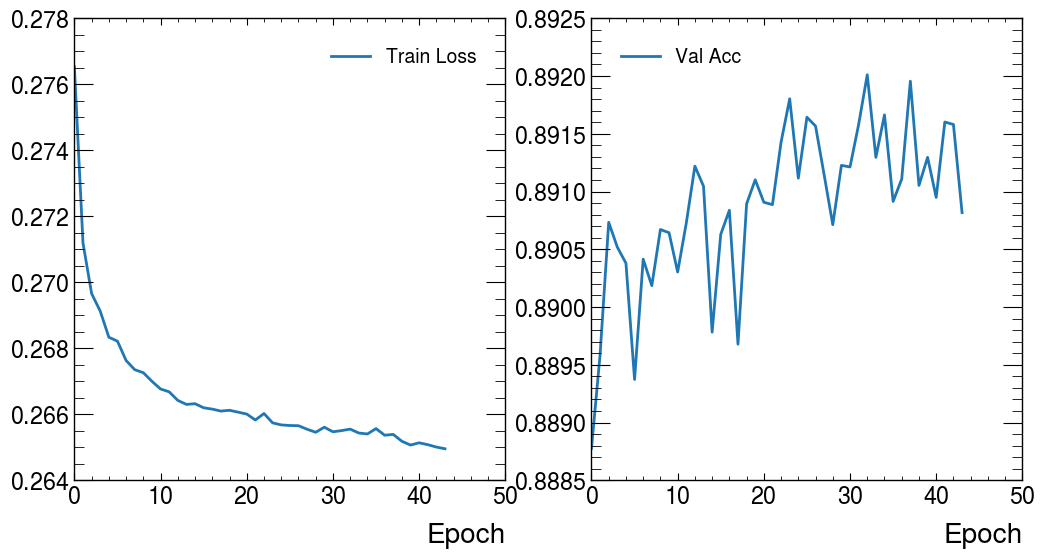

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].plot(clf.loss_curve_, label="Train Loss")
ax[1].plot(clf.validation_scores_, label="Val Acc")
ax[0].legend()
ax[1].legend()

ax[0].set_xlabel("Epoch")
ax[1].set_xlabel("Epoch")
fig.savefig("./plots_ml_morevars/MLP_training_curve.png")

In [16]:
clf.feature_names_in_

array(['Deta_jj', 'Dphi_jj', 'M_jj', 'Met', 'ZetaLep', 'Jet1Pt',
       'Jet1Eta', 'Jet2Pt', 'Jet2Eta', 'Ht', 'Eta_W', 'Eta_Z', 'Lep1Eta',
       'Lep2Eta', 'Lep3Eta'], dtype=object)

## Distribution of testing

In [17]:
y_test_decisions = clf.predict_proba(X_test[training_features])[:, 1]

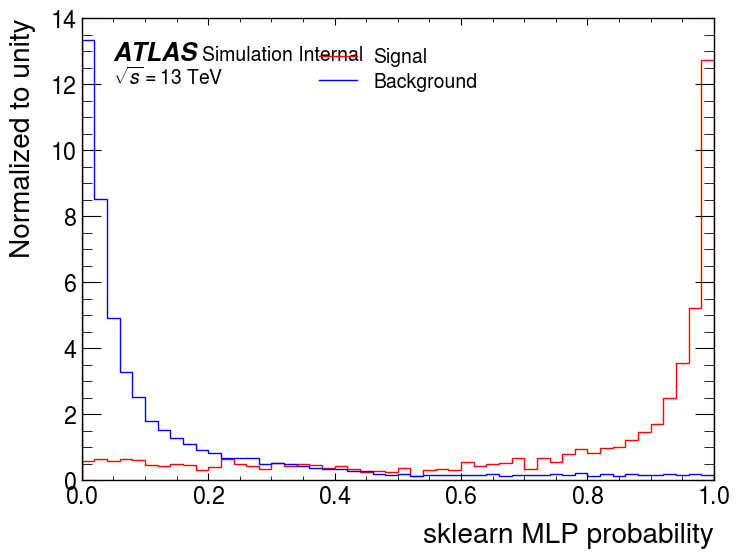

In [18]:
event_weight_idx = X.columns.get_loc("WeightNormalized")
y_test_sig_id = np.where(y_test == 1)[0]
y_test_bkg_id = np.where(y_test == 0)[0]

mlp_score_bin_edges = np.linspace(0, 1, 51)

sig_bin_contents, sig_bin_edges = np.histogram(
    y_test_decisions[y_test_sig_id],
    weights=X_test.iloc[y_test_sig_id, event_weight_idx],
    bins=mlp_score_bin_edges,
    density=True,
)
bkg_bin_contents, bkg_bin_edges = np.histogram(
    y_test_decisions[y_test_bkg_id],
    weights=X_test.iloc[y_test_bkg_id, event_weight_idx],
    bins=mlp_score_bin_edges,
    density=True,
)

fig, ax = plt.subplots()
hep.histplot(
    sig_bin_contents, sig_bin_edges, label="Signal", ax=ax, color="red"
)
hep.histplot(
    bkg_bin_contents,
    bkg_bin_edges,
    label="Background",
    ax=ax,
    color="blue",
)

hep.atlas.label("Internal", data=False)
hep.atlas.set_ylabel("Normalized to unity")
hep.atlas.set_xlabel("sklearn MLP probability")
ax.legend()
fig.savefig("./plots_ml_morevars/sklearn_MLP_score.png")

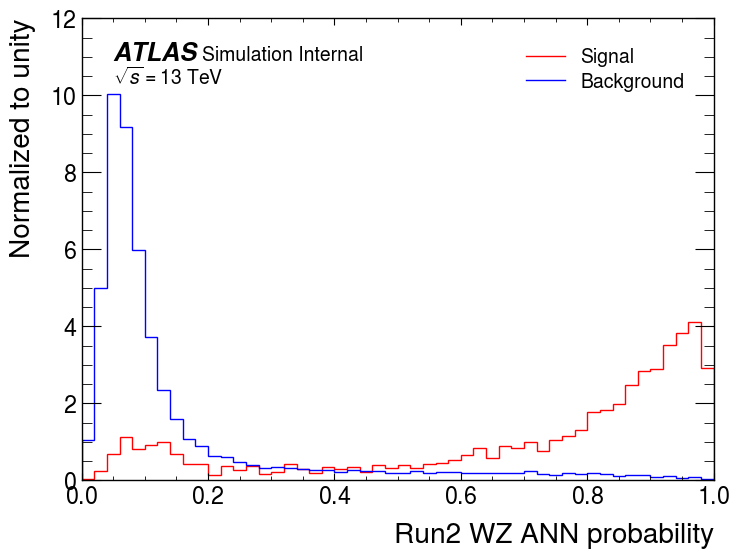

In [19]:
pSignal_GM_idx = X.columns.get_loc("pSignal_GM")
sig_bin_contents, sig_bin_edges = np.histogram(
    X_test.iloc[y_test_sig_id, pSignal_GM_idx],
    weights=X_test.iloc[y_test_sig_id, event_weight_idx],
    bins=mlp_score_bin_edges,
    density=True,
)
bkg_bin_contents, bkg_bin_edges = np.histogram(
    X_test.iloc[y_test_bkg_id, pSignal_GM_idx],
    weights=X_test.iloc[y_test_bkg_id, event_weight_idx],
    bins=mlp_score_bin_edges,
    density=True,
)

fig, ax = plt.subplots()
hep.histplot(
    sig_bin_contents, sig_bin_edges, label="Signal", ax=ax, color="red"
)
hep.histplot(
    bkg_bin_contents,
    bkg_bin_edges,
    label="Background",
    ax=ax,
    color="blue",
)

hep.atlas.label("Internal", data=False)
hep.atlas.set_ylabel("Normalized to unity")
hep.atlas.set_xlabel("Run2 WZ ANN probability")
ax.legend()
fig.savefig("./plots_ml_morevars/run2wz_ANN_score.png")

## ROC

In [20]:
from sklearn.metrics import roc_curve, auc, roc_auc_score


def Draw_ROC(y_true, y_sklearn_mlp, y_run2_wz_prob, X_weight, use_event_weight=True):
    # Compute ROC curve and area under the curve
    fpr_skl_mlp, tpr_skl_mlp, thresholds = roc_curve(
        y_true, y_sklearn_mlp, sample_weight=X_weight
    )
    fpr_run2_ann, tpr_run2_ann, thresholds_run2_ann = roc_curve(
        y_true, y_run2_wz_prob, sample_weight=X_weight
    )

    # Note: x is neither increasing nor decreasing :
    # because of event weights, fpr is not increasing or decreasing
    sorted_index = np.argsort(fpr_skl_mlp)
    fpr_skl_mlp = fpr_skl_mlp[sorted_index]
    tpr_skl_mlp = tpr_skl_mlp[sorted_index]

    sorted_index = np.argsort(fpr_run2_ann)
    fpr_run2_ann = fpr_run2_ann[sorted_index]
    tpr_run2_ann = tpr_run2_ann[sorted_index]

    roc_auc_skl_mlp = auc(fpr_skl_mlp, tpr_skl_mlp)
    roc_auc_run2_ann = auc(fpr_run2_ann, tpr_run2_ann)

    fig, ax = plt.subplots()
    ax.plot(
        fpr_skl_mlp,
        tpr_skl_mlp,
        lw=1,
        label="ROC_sklearn_MLP (area = %0.3f)" % (roc_auc_skl_mlp),
    )
    ax.plot(
        fpr_run2_ann,
        tpr_run2_ann,
        lw=1,
        label="ROC_run2_ANN (area = %0.3f)" % (roc_auc_run2_ann),
    )

    ax.plot([1.0, 0.0], [1.0, 0.0], "--", color=(0.6, 0.6, 0.6), label="Luck")
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    if use_event_weight:
        ax.set_title(f"ROC with Event Weights")
        file_name = "ROC_compare_eventweight.png"
    else:
        ax.set_title(f"ROC without Event Weights")
        file_name = "ROC_compare_noeventweight.png"
        
    ax.legend(loc="lower right")
    ax.grid()
    hep.atlas.label("Internal", data=False)
    fig.savefig(f"./plots_ml_morevars/{file_name}")

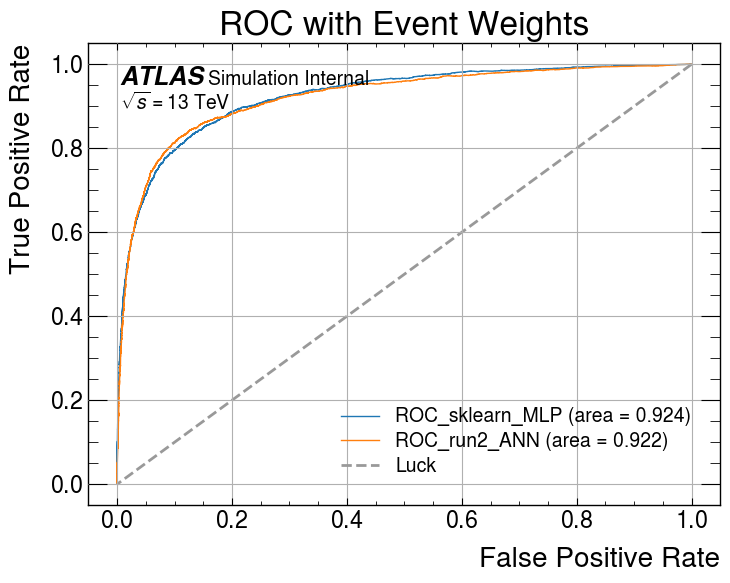

In [21]:
Draw_ROC(
    y_true=y_test,
    y_sklearn_mlp=y_test_decisions,
    y_run2_wz_prob=X_test.iloc[:, pSignal_GM_idx],
    X_weight=X_test.iloc[:, event_weight_idx],
    use_event_weight=True,
)

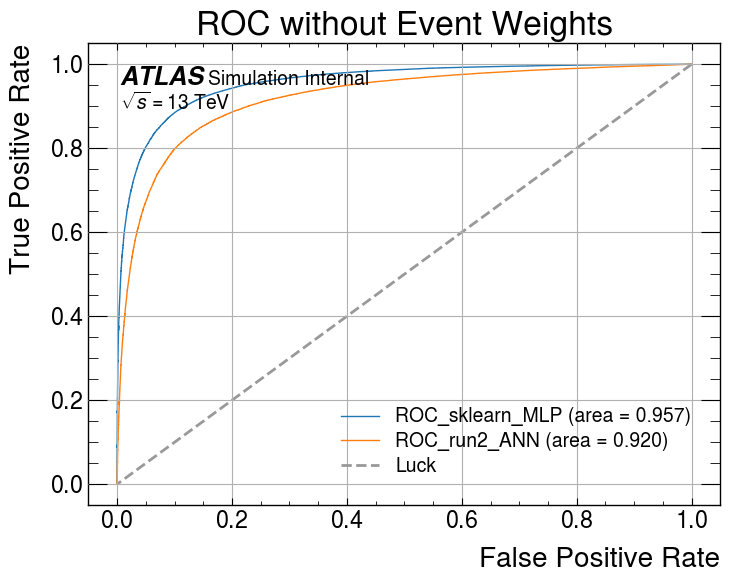

In [22]:
# Without event weights 
Draw_ROC(
    y_true=y_test,
    y_sklearn_mlp=y_test_decisions,
    y_run2_wz_prob=X_test.iloc[:, pSignal_GM_idx],
    X_weight=np.ones_like(y_test),
    use_event_weight=False,
)

## Overtraining

In [23]:
y_train_decisions = clf.predict_proba(X_train[training_features])[:, 1]

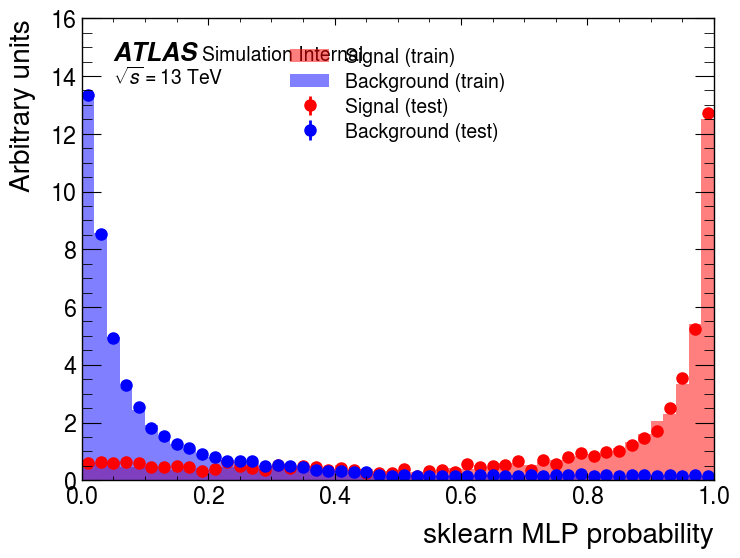

In [24]:
event_weight_idx = X.columns.get_loc("WeightNormalized")
y_test_sig_id = np.where(y_test == 1)[0]
y_test_bkg_id = np.where(y_test == 0)[0]
y_train_sig_id = np.where(y_train == 1)[0]
y_train_bkg_id = np.where(y_train == 0)[0]

y_train_decisions = clf.predict_proba(X_train[training_features])[:, 1]
y_train_sig_decisions = y_train_decisions[y_train_sig_id]
y_train_bkg_decisions = y_train_decisions[y_train_bkg_id]
y_test_decisions = clf.predict_proba(X_test[training_features])[:, 1]
y_test_sig_decisions = y_test_decisions[y_test_sig_id]
y_test_bkg_decisions = y_test_decisions[y_test_bkg_id]

decisions = []
decisions.append(y_train_sig_decisions)
decisions.append(y_train_bkg_decisions)
decisions.append(y_test_sig_decisions)
decisions.append(y_test_bkg_decisions)


custom_bins = np.linspace(0, 1, 51)
custom_bin_width = custom_bins[1] - custom_bins[0]
custom_bin_center = (custom_bins[:-1] + custom_bins[1:]) / 2

fig, ax = plt.subplots()
ax.hist(
    decisions[0],
    weights=X_train.iloc[np.where(y_train == 1)[0], event_weight_idx],
    color="r",
    alpha=0.5,
    bins=custom_bins,
    histtype="stepfilled",
    density=True,
    label="Signal (train)",
)
ax.hist(
    decisions[1],
    weights=X_train.iloc[np.where(y_train == 0)[0], event_weight_idx],
    color="b",
    alpha=0.5,
    bins=custom_bins,
    histtype="stepfilled",
    density=True,
    label="Background (train)",
)

hist, bins = np.histogram(
    decisions[2],
    weights=X_test.iloc[np.where(y_test == 1)[0], event_weight_idx],
    bins=custom_bins,
    density=True,
)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale

plt.errorbar(
    custom_bin_center, hist, yerr=err, fmt="o", c="r", label="Signal (test)"
)

hist, bins = np.histogram(
    decisions[3],
    weights=X_test.iloc[np.where(y_test == 0)[0], event_weight_idx],
    bins=custom_bins,
    density=True,
)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale

ax.errorbar(
    custom_bin_center,
    hist,
    yerr=err,
    fmt="o",
    c="b",
    label="Background (test)",
)
ax.set_xlabel("sklearn MLP probability")
ax.set_ylabel("Arbitrary units")
ax.legend(loc="best")
ax.set_label("Overtraining test")

hep.atlas.label("Internal", data=False)
fig.savefig("./plots_ml_morevars/Overtraining_test.png")

# PileUp correlation

In [25]:
y_test_decisions

array([0.07529806, 0.9696419 , 0.00825488, ..., 0.77102464, 0.00553689,
       0.1245041 ], dtype=float32)

In [29]:
test_dataset = pd.concat([X_test, y_test], axis=1) 

In [30]:
test_dataset['y_test_decisions'] = y_test_decisions 

In [31]:
test_dataset

,Yields,isMC,Channel,Year,NormSF,WeightSign,WeightNormalized,Weight,M_WZ,M_123,...,Lep1WeightW,Lep2WeightW,Lep3WeightW,Lep1Level,Lep2Level,Lep3Level,Ht,pSignal_GM,target,y_test_decisions
968412,0,364253,3,17,0.018323,-1.0,0.003062,0.167143,659.319763,482.645447,...,0.974024,0.992122,0.993749,123,123,123,1.505985,0.036564,0.0,0.075298
42884,0,502515,4,17,0.355766,0.0,0.011826,0.033242,504.703400,217.698273,...,0.984424,0.992422,0.991919,123,123,123,-0.541986,0.798762,1.0,0.969642
929048,0,364253,4,17,0.018323,-1.0,0.001885,0.102892,409.013824,278.051758,...,0.951204,0.961188,1.006528,123,123,123,0.060030,0.048856,0.0,0.008255
111900,0,502520,2,18,0.370766,0.0,-0.003853,-0.010392,582.420593,433.681152,...,0.990058,0.984439,0.986070,123,123,123,0.609567,0.136706,1.0,0.530393
1959994,0,364253,3,17,0.018323,-1.0,0.001131,0.061754,236.611526,191.894302,...,0.994088,0.973241,0.989655,123,123,123,-1.075896,0.048957,0.0,0.037503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045654,0,364253,2,17,0.018323,-1.0,0.000322,0.017597,349.153442,270.268188,...,0.995840,0.991498,0.984724,123,123,123,-0.417241,0.057693,0.0,0.151514
9206,0,450771,1,1516,0.386571,0.0,0.014576,0.037705,686.501831,308.031006,...,0.988998,0.986028,0.997591,123,123,123,-0.210851,0.505570,1.0,0.922200
84763,0,502514,3,18,0.342359,0.0,0.014029,0.040977,314.188599,287.217834,...,0.979469,0.996846,0.992585,123,122,123,-1.029937,0.882842,1.0,0.771025
1492910,0,364253,2,17,0.018323,-1.0,0.000072,0.003917,333.197449,182.198120,...,0.989064,0.988361,0.984424,123,123,123,1.865083,0.044044,0.0,0.005537


In [32]:
mu_bins = np.linspace(0, 100, 11)
test_dataset['AvMu_binidx'] = pd.cut(test_dataset['AvMu'], bins=mu_bins, labels=False)
grouped_test_dataset_byAvMu = test_dataset.groupby('AvMu_binidx')


In [33]:
grouped_test_dataset_byAvMu.get_group(0)

,Yields,isMC,Channel,Year,NormSF,WeightSign,WeightNormalized,Weight,M_WZ,M_123,...,Lep2WeightW,Lep3WeightW,Lep1Level,Lep2Level,Lep3Level,Ht,pSignal_GM,target,y_test_decisions,AvMu_binidx
25919,0,502518,4,1516,0.299771,0.0,7.361041e-03,2.455557e-02,543.079041,321.024719,...,0.970121,0.998838,122,123,123,-0.277348,0.956893,1.0,0.997467,0
2171904,0,364253,4,17,0.018323,-1.0,3.871854e-04,2.113169e-02,282.241699,157.243179,...,0.971403,0.964977,123,123,123,2.365336,0.118140,0.0,0.012918,0
29551,0,502514,4,1516,0.281192,0.0,-2.006581e-06,-7.135994e-06,370.537292,255.081238,...,1.023550,1.006847,123,122,123,-0.807128,0.950381,1.0,0.995483,0
994075,0,364253,1,17,0.018323,-1.0,0.000000e+00,0.000000e+00,191.968719,163.436279,...,0.996131,0.978038,123,123,123,-1.192759,0.052662,0.0,0.012497,0
431965,0,364253,2,1516,0.030810,-1.0,4.804806e-02,1.559479e+00,251.832306,174.987549,...,0.993950,0.992721,123,123,123,-1.172962,0.029611,0.0,0.008230,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102303,0,502522,4,18,0.374300,0.0,0.000000e+00,0.000000e+00,940.333923,864.068176,...,0.978804,0.988369,123,123,123,0.397069,0.727588,1.0,0.992840,0
8459,0,502522,1,1516,0.323801,0.0,9.146040e-08,2.824591e-07,814.358765,523.039978,...,0.995916,0.972994,123,123,123,0.185876,0.411610,1.0,0.986827,0
272528,0,364253,1,1516,0.030810,-1.0,3.066189e-06,9.951823e-05,277.747070,169.791016,...,0.991776,1.000879,122,123,123,-0.948160,0.019413,0.0,0.024612,0
176896,0,364253,2,1516,0.030810,-1.0,2.842048e-07,9.224335e-06,189.169708,144.084869,...,0.995270,0.881714,122,123,123,-1.093193,0.069236,0.0,0.062431,0


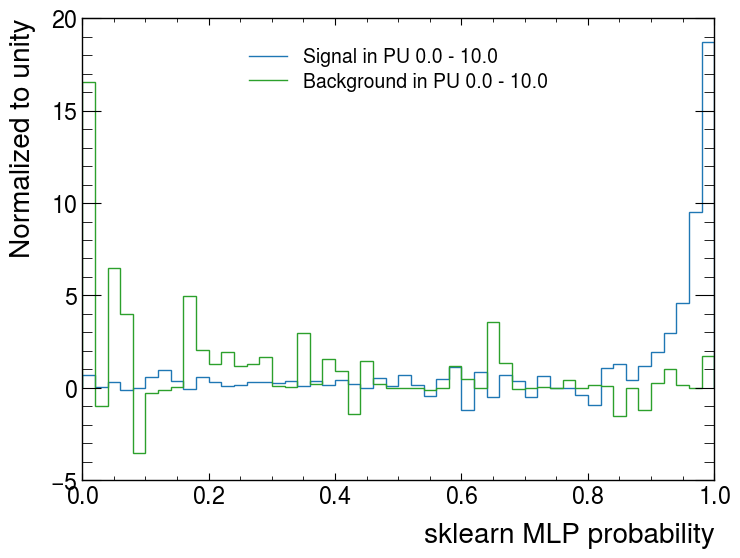

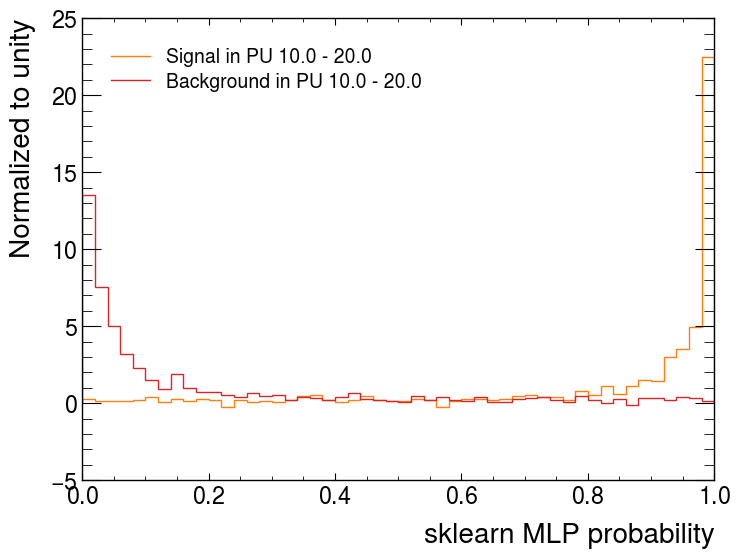

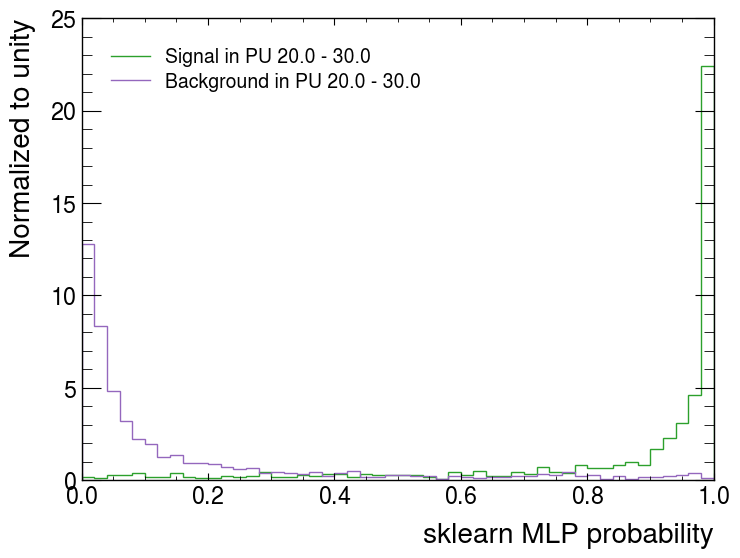

In [48]:
mlp_score_bin_edges = np.linspace(0, 1, 51)

for i in range(3):
    fig, ax = plt.subplots()
    X = grouped_test_dataset_byAvMu.get_group(i)
    y_test = X['target']
    y_test_decisions = X['y_test_decisions']
    
    event_weight_idx = X.columns.get_loc("WeightNormalized")
    y_test_sig_id = np.where(y_test == 1)[0]
    y_test_bkg_id = np.where(y_test == 0)[0]


    sig_bin_contents, sig_bin_edges = np.histogram(
        y_test_decisions.iloc[y_test_sig_id],
        weights=X_test.iloc[y_test_sig_id, event_weight_idx],
        bins=mlp_score_bin_edges,
        density=True,
    )
    bkg_bin_contents, bkg_bin_edges = np.histogram(
        y_test_decisions.iloc[y_test_bkg_id],
        weights=X_test.iloc[y_test_bkg_id, event_weight_idx],
        bins=mlp_score_bin_edges,
        density=True,
    )

    hep.histplot(
        sig_bin_contents, 
        sig_bin_edges, 
        label=f"Signal in PU {mu_bins[i]} - {mu_bins[i+1]}", 
        ax=ax, color=f"C{i}",
    )
    hep.histplot(
        bkg_bin_contents,
        bkg_bin_edges,
        label=f"Background in PU {mu_bins[i]} - {mu_bins[i+1]}",
        ax=ax,
        color=f"C{i+2}",
    )

    # hep.atlas.label("Internal", data=False)
    hep.atlas.set_ylabel("Normalized to unity")
    hep.atlas.set_xlabel("sklearn MLP probability")
    ax.legend()
# fig.savefig("./plots_ml_morevars/sklearn_MLP_score.png")

## just compare two 

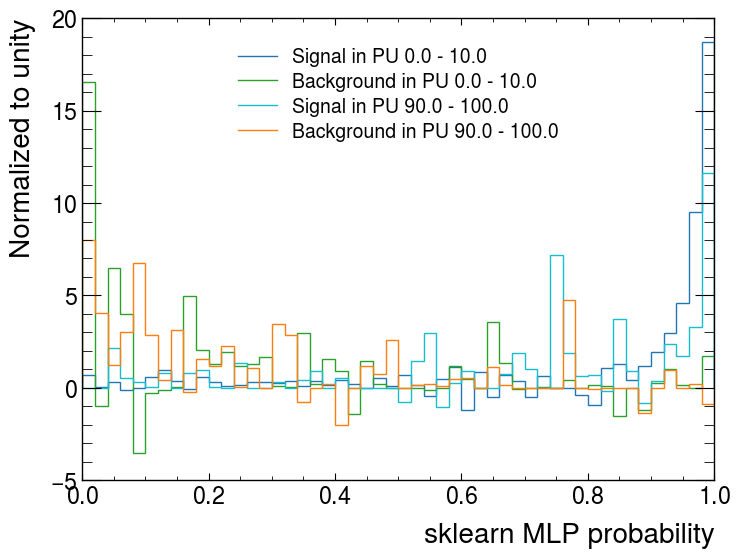

In [49]:
mlp_score_bin_edges = np.linspace(0, 1, 51)
fig, ax = plt.subplots()

for i in [0, 9]:
    X = grouped_test_dataset_byAvMu.get_group(i)
    y_test = X['target']
    y_test_decisions = X['y_test_decisions']
    
    event_weight_idx = X.columns.get_loc("WeightNormalized")
    y_test_sig_id = np.where(y_test == 1)[0]
    y_test_bkg_id = np.where(y_test == 0)[0]


    sig_bin_contents, sig_bin_edges = np.histogram(
        y_test_decisions.iloc[y_test_sig_id],
        weights=X_test.iloc[y_test_sig_id, event_weight_idx],
        bins=mlp_score_bin_edges,
        density=True,
    )
    bkg_bin_contents, bkg_bin_edges = np.histogram(
        y_test_decisions.iloc[y_test_bkg_id],
        weights=X_test.iloc[y_test_bkg_id, event_weight_idx],
        bins=mlp_score_bin_edges,
        density=True,
    )

    hep.histplot(
        sig_bin_contents, 
        sig_bin_edges, 
        label=f"Signal in PU {mu_bins[i]} - {mu_bins[i+1]}", 
        ax=ax, color=f"C{i}",
    )
    hep.histplot(
        bkg_bin_contents,
        bkg_bin_edges,
        label=f"Background in PU {mu_bins[i]} - {mu_bins[i+1]}",
        ax=ax,
        color=f"C{i+2}",
    )

    # hep.atlas.label("Internal", data=False)
hep.atlas.set_ylabel("Normalized to unity")
hep.atlas.set_xlabel("sklearn MLP probability")
ax.legend()
# fig.savefig("./plots_ml_morevars/sklearn_MLP_score.png")